In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import glob

## 1. Leitura e tratamento de dados de entrada - Falhas:

In [16]:
path = r'3W\4' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")

li = {}
c = 0

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    df = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL','P-JUS-CKGL'])
    li[c] = df
    c += 1
    
    
frame = pd.concat(li, axis=0, ignore_index=True)

In [21]:
from statsmodels.tsa.ar_model import AutoReg

In [15]:
pd.value_counts(pd.isnull(frame[frame.columns[5]]) == True)

True     1243569
False    1218507
Name: P-JUS-CKGL, dtype: int64

In [19]:
len(li)

344

In [22]:
dados = li # dicionário 
Feat = []
lags = 30
for i in range(0, 149):
# for i in range(0, 2):
    ch = dados[i]
    chss = []
    ch1 = AutoReg(ch[ch.columns[0]].values,lags = lags).fit()
    ch2 = AutoReg(ch[ch.columns[1]].values,lags = lags).fit()
    ch3 = AutoReg(ch[ch.columns[2]].values,lags = lags).fit()
    ch4 = AutoReg(ch[ch.columns[3]].values,lags = lags).fit()
    ch5 = AutoReg(ch[ch.columns[4]].values,lags = lags).fit()
    ch6 = AutoReg(ch[ch.columns[5]].values,lags = lags).fit()        
    ar_models = np.concatenate([ch1.params, ch2.params, ch3.params,
                                ch4.params, ch5.params, ch6.params])
    Feat.append(ar_models)
    
# Só foi até o 149 -> apareceu nan's!!! 
# Talvez fazer um modelo de para completar dados faltantes!!!

MissingDataError: exog contains inf or nans

Text(0.5, 0, 'n_components')

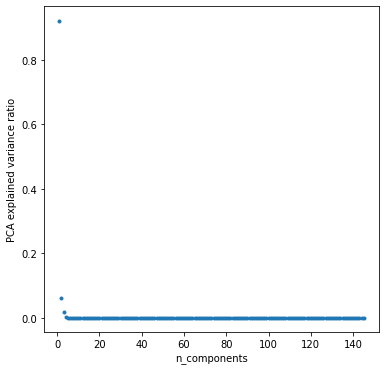

In [41]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Feat)

# Plot the PCA spectrum
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(6, 6))

ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, ".", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.set_xlabel("n_components")

In [42]:
pca = PCA(n_components = 0.95)
Feat_reduced_falt = pca.fit_transform(Feat)
Feat_reduced_falt.shape

(145, 2)

## 2. Leitura e tratamento de dados referentes a nominais:

In [43]:
path = r'3W\0' # use your path 3W\4
all_files = glob.glob(path + "/*.csv")

li = {}
c = 0
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header = 0)
    df = df.drop(columns = ['timestamp','QGL','T-JUS-CKGL'])
    li[c] = df
    c += 1

frame = pd.concat(li, axis=0, ignore_index=True)

In [44]:
dados = li # dicionário 
Feat = []
lags = 30
for i in range(0, 150):
# for i in range(0, 2):
    ch = dados[i]
    chss = []
    ch1 = AutoReg(ch[ch.columns[0]].values,lags = lags).fit()
    ch2 = AutoReg(ch[ch.columns[1]].values,lags = lags).fit()
    ch3 = AutoReg(ch[ch.columns[2]].values,lags = lags).fit()
    ch4 = AutoReg(ch[ch.columns[3]].values,lags = lags).fit()
    ch5 = AutoReg(ch[ch.columns[4]].values,lags = lags).fit()
    ch6 = AutoReg(ch[ch.columns[5]].values,lags = lags).fit()        
    ar_models = np.concatenate([ch1.params, ch2.params, ch3.params,
                                ch4.params, ch5.params, ch6.params])
    Feat.append(ar_models)
    
# Só foi até o 149 -> apareceu nan's!!!
        

Text(0.5, 0, 'n_components')

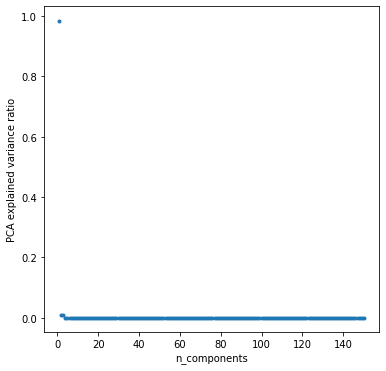

In [45]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Feat)

# Plot the PCA spectrum
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(6, 6))

ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, ".", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.set_xlabel("n_components")

In [46]:
pca = PCA(n_components = 2)
Feat_reduced_nom = pca.fit_transform(Feat)
Feat_reduced_nom.shape

(150, 2)

In [47]:
# Adicionando classes de dados ao dataset:
classe_falt = np.ones(shape = (145,1))
classe_nom = np.zeros(shape = (150,1))

d1 = np.concatenate((Feat_reduced_nom, classe_nom), axis=1)
d2 = np.concatenate((Feat_reduced_falt, classe_falt), axis=1)
Dados = np.concatenate((d1,d2), axis = 0)
Dados[:2,:]

array([[14052.01910651,  -760.49068611,     0.        ],
       [15105.02046647,  -628.33378984,     0.        ]])

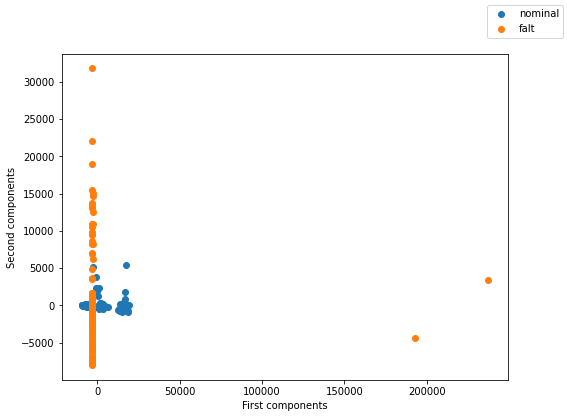

In [49]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(Feat_reduced_nom[:,0], Feat_reduced_nom[:,1],  label = 'nominal')
ax.scatter(Feat_reduced_falt[:,0],Feat_reduced_falt[:,1], label = 'falt')
ax.set_xlabel('First components')
# ax.set_xticks(range(0,50000))
ax.set_ylabel('Second components')
fig.legend()

## 3. Modelo de aprendizado de máquina:

In [50]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [51]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### a) SVM

c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


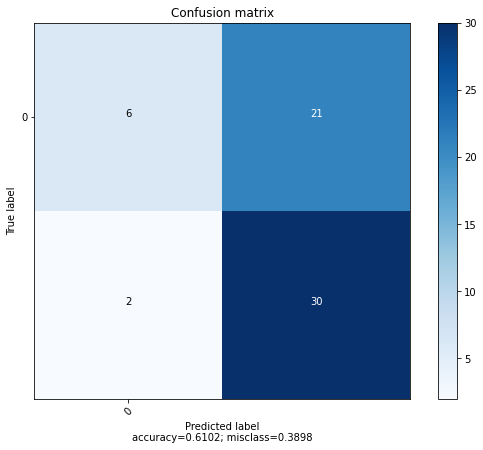

In [52]:
from sklearn.svm import LinearSVC

standart_scaler = preprocessing.StandardScaler()
Feat_scaler = standart_scaler.fit_transform(Dados[:,:2])
Y = Dados[:,-1]

x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.2, random_state = 0 )
modelo_svc = LinearSVC(C = 1, loss = 'hinge', random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

In [56]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.model_selection import RepeatedKFold

In [54]:
rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = 42)
rkf.split(x_train, y_train)

# Randomized Search
rand_parameters = [{'C':range(1,100), 'loss':['hinge', 'square_hinge']}]
modelo_svc = LinearSVC() 
random_search_svm = RandomizedSearchCV(modelo_svc, rand_parameters, verbose = 0, n_iter = 100,
                                       n_jobs = -1, cv = rkf, scoring = 'neg_mean_squared_error', random_state=42)
random_search_svm.fit(x_train, y_train)
BPSVC = random_search_svm.best_params_

c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12500 fits failed out of a total of 25000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\luissantos\AppData\Local

c:\Users\luissantos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


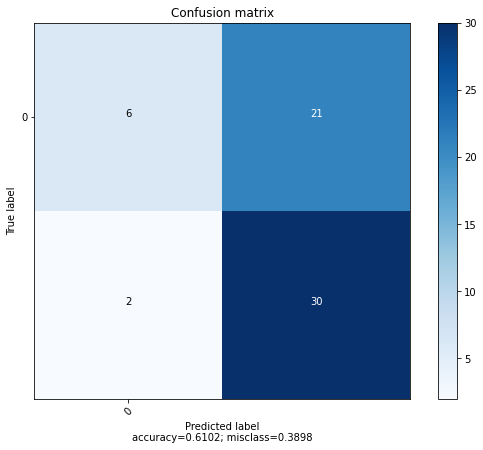

In [59]:
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.2, random_state = 0 )
modelo_svc = LinearSVC(C = 67, loss = 'hinge', random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

#### Truque do Kernel

##### a. Kernel polinomial:

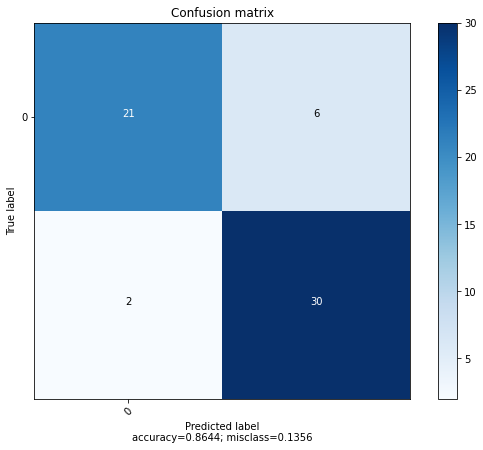

In [63]:
modelo_svc = SVC(C = 63, kernel = 'poly', degree = 2, random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

##### a. Kernel Gaussiano:

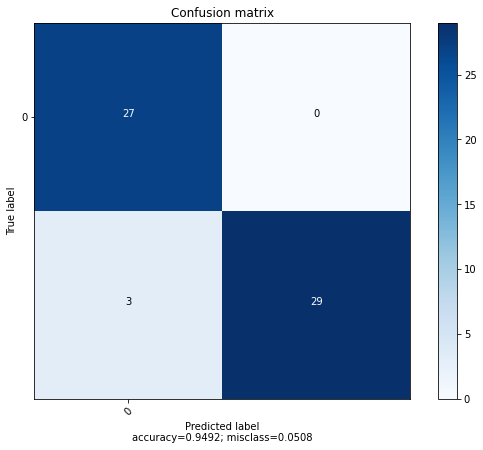

In [68]:
modelo_svc = SVC(C = 63, kernel = 'rbf', gamma = 5, random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(0,1))

### b) Random Forest

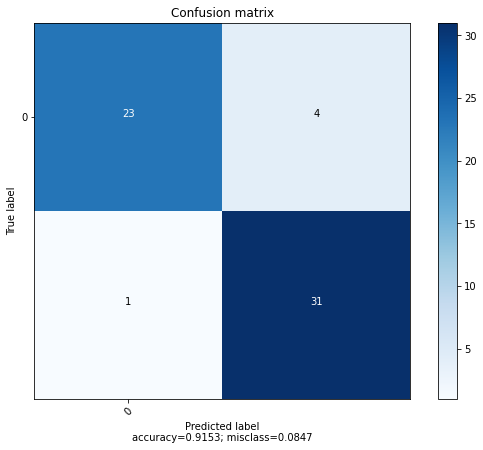

In [69]:
from scipy.stats import randint,uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 500, n_jobs= -1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(0,1))

In [70]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            }


# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [71]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 70}

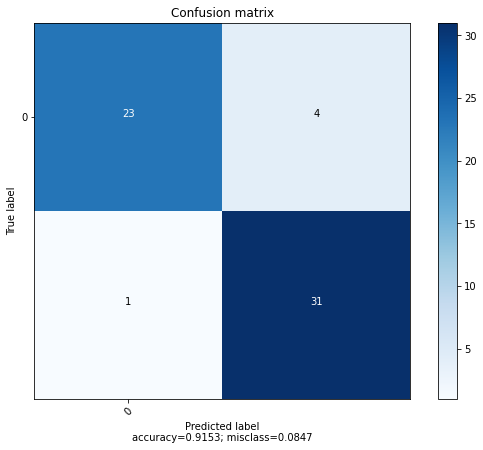

In [72]:
y_pred = rf_random.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(0,1))

# DISCUTIR E-MAIL DO HELON